# Mapa Litoestratigráfico Preditivo - Diamantina (MG)

##### Trabalho de Conclusão de Curso - Geologia / IGC / UFMG

Autores: _Franco Naghetini_ & _Guilherme Silveira_

## Introdução

O trabalho tem como objetivo a produção de um **mapa litoestratigráfico preditivo 1:25.000**, a partir de dados de sensores remotos e dados do mapeamento geológico realizado pelos alunos da disciplina de Estágio Supervisionado do ano de 2018, na região de Diamantina. As predições das unidades litoestratigráficas serão realizadas, utilizando algoritmos de *Machine Learning* (aprendizado supervisionado).

O produto gráfico final (*i.e.*, mapa litoestratigráfico preditivo) pode ser utilizado como um meio de reconciliação entre os dados de mapeamento de campo e os sensores remotos. Nesse sentido, as inconsistências entre o mapa geológico e o mapa litoestratigráfico preditivo podem fornecer *insights* e orientar futuras campanhas de mapeamento na região de Diamantina (MG).

## Contexto geológico
 A área de estudo está localizada no Sudeste brasileiro próximo a cidade de Diamantina no contexto geotectônico da borda leste do Cráton São Francisco. A Serra do Espinhaço (SDE) estende-se por mais de 1200 Km em direção meridiana (Knauer, 2007), indo desde a borda Leste do Quadrilátero Ferrífero até o norte do estado da Bahia. A SDE pode ser dividida nos domínios setentrional e meridional, sendo a área de estudo pertencente à essa última. A parte Meridional, localizada no estado de Minas Gerais, possui um grande acervo de conhecimento geológico adquirido, principalmente, a partir da descoberta dos depósitos diamantíferos em diamantina (Knauer op.cit.), além disso, a área vem sendo estutada por décadas por centenas de alunos e professores de diversos institutos de geociências do país, a partir do programa de estagio supervisionado.

Na região de estudo afloram principalmente os litotipos do Supergrupo Rio Paraúna definido por Fogaça et al. (1984), principalmente os xistos do Grupo Costa Sena e os quartzitos Formação Bandeirinha, alem das rochas basais do Supergrupo Espinhaço.

### Trabalhos Anteriores
Um dos primeiros estudos da região da Serra do Espinhaço data ainda do século XVIII realizado
por Viera Couto (Renger, 1979). Uma das maiores contribuições iniciais para a geologia, não só
do Espinhaço, mas de grande parte do Sudeste brasileiro, foi feita pelo naturalista Ludwig Von
Eschwege durante sua passagem pelo Brasil no início do século XIX. Durante seu trabalho,
descrito no Pluto Brasiliensis de 1833, ele descreve a Serra do Espinhaço como um grande
conjunto de Serras que funcionariam como o grande divisor de águas no território sudeste
brasileiro (Derby, 1906). Eschwege dá início, ainda, à primeira tentativa de divisão
estratigráfica (Renger ,op.cit.).
Outros trabalhos posteriores são importantes para o entendimento da geologia da região. Vale,
então, citar os trabalhos realizados por Derby entre os sécs. XVIII e XIX. Derby (1906) em seu
trabalho, publicado em The Jounal of Geology, sugere que a Serra do Espinhaço é composta por
três grupos de rochas: 1º os Gnaisses e os mica xistos; 2º Xistos, quartzitos e calcários nas
regiões auríferas (Quadrilátero ferrífero) e 3º quartzitos e arenitos em regiões diamantíferas.
Diversos autores trabalharam desde então com a geologia da Serra do Espinhaço, na tentativa de
propor uma estratigrafia mais detalhada e compreender os eventos geológicos envolvidos na
formação da mesma. Diversas propostas estratigráficas, então, foram feitas destacando o
trabalho realizado por Pflug (1968), onde o mesmo propõe a divisão da série Minas na região de
Diamantina, dividindo essa sequência em 8 formações litoestratifgráficas, até hoje adotadas.
16
Outros trabalhos de grande relevância e as proposições sobre a geologia do Espinhaço podem
ser encontrados nos artigos publicados por Moraes & Guimarães (1930); Pflug & Renger
(1973); Schol & Fogaça (1979), como descrito em Renger (1979).

### Estratigrafia

A estratigrafia da região de Diamantina foi amplamente discutida nas últimas décadas e uma de
suas propostas foi feita por Almeida Abreu (1995), segundo a ***Figura 1***. Contudo, outros autores
vêm propondo outras compartimentações para seus grupos e formações, como será discutido
neste trabalho. Serão tratados os tópicos Embasamento, Supergrupo Rio Paraúna e Supergrupo
Espinhaço.

**Embasamento**

O Complexo Basal da região da Serra do Espinhaço corresponde à faixa mediana-central da
mesma, constituída por rochas graníticas, chamadas de Complexo Gouveia. Também ocorrem,
ocasionalmente, rochas gnáissicas (Almeida Abreu, 1995; Knauer, 1990). Já no leste e sul, há
ocorrência de gnaisses e granitos, charnockitos e granulitos subordinados (Almeida Abreu,
1995). Segundo Knauer (1990), também se observa ocorrências menos expressivas de corpos
anfibolíticos e produtos de sua milonitização.
O Complexo possui idades arqueanas, segundo Teixeira et al. (1990) in Almeida Abreu (1995)
e Brito Neves et al. (1979) in Knauer (1990) e proterozoicas, segundo Teixeira et al. 1990 in
Almeida Abreu 1995. De acordo com Brito Neves et al. (1979) in Dossin et al. (1984), as rochas
do embasamento incluem rochas graníticas e migmatíticas, além de, segundo Carvalho (1982)
in Dossin et al. (1984), anatexitos, protomilonitos, milonitos, ultramilonitos e corpos isolados de
anfibolitos.

**Supergrupo Rio Paraúna**

Sobreposto ao embasamento, encontra-se o Supergrupo Rio Paraúna que, segundo Fogaça et al.
(1984) e Almeida Abreu (1995), são compostos pelo Grupo Pedro Pereira e pelo Grupo Costa
Sena, da base para o topo. O Grupo Pedro Pereira é subdividido nas Unidades
ultramáfica/máfica e vulcanossedimentar, enquanto o Grupo Costa Sena é composto pelas
Formações Barão de Guaicuí e Bandeirinha, englobando sucessões epiclásticas finas e grossas,
respectivamente (Fogaça et al. 1984).
As definições do Grupo Pedro Pereira são feitas por Almeida Abreu (1995) descrevendo uma
associação de rochas meta-máficas, ultramáficas, ácidas e também metassedimentos de origem
química, sobre o qual Machado et al. (1989) cita idades de 2971 +/- 16 Ma. Já o grupo Costa
Sena é descrito como uma sequência de sericita-xistos com frequente presença de cianita por
Almeida Abreu (1995), e como sequências marinha com vulcanismo ácido calcoalcalino e
continental a até marinha rasa, correspondentes respectivamente às Formações Barão de Guaicuí
e Bandeirinha, por Knauer (1990). Essa sequência supracrustal ao embasamento é chamada por
Dossin et al. (1984) de Supergrupo Rio das Velhas, cuja porção basal é composta por uma
associação de clorita-xistos e mica xistos, enquanto a porção superior é constituída por quartzomica-
xistos com cianita e quartzitos com lentes de metaconglomerados.

**Supergrupo Espinhaço**

Uma das primeiras divisões feitas para o pacote de rochas sobreposto ao Supergrupo Rio
Paraúna foi proposta no trabalho de Pflug (1968), no qual menciona-se oito formações para a
Série Minas, correspondente nesse estudo ao Supergrupo Espinhaço. Esse autor descreve a
primeira delas, Formação São João da Chapada, como quartzitos médios a grossos com
estratificações cruzadas, apresentando intercalações de seixos na base e lâminas de filito na
porção superior. De acordo com Schöll & Fogaça (1979), essa formação se encontra na porção
basal do Supergrupo e é composta por quartzitos metaconglomerados, filitos e metavulcânicas.
Já Almeida Abreu (1995) a descreve como pertencente ao Grupo Guinda do Supergrupo
Espinhaço, englobando uma sequência de sedimentos continentais com metavulcânicas
intercaladas a eles. A Formação é subdivida por Schöll & Fogaça (1979) in Knauer (1990) em
três níveis informais, chamados de A, B e C. O nível A é caracterizado por quartzitos,
metaconglomerados e/ou metabrechas, enquanto o nível B se destaca pela presença de filitos
hematíticos intercalados principalmente por clorita-xistos e turmalinitos finos. O nível C por sua
vez é composto por quartzitos médios a grossos com pequenos conteúdos de ferro de maneira
geral.
18
Acima da Formação São João da Chapada, segundo Pflug (1968), encontra-se a Formação Sopa
Brumadinho, a qual possui principalmente quartzitos e filitos, por vezes intercalados por
conglomerados polimíticos e monomíticos. Também foi observado pelo autor lentes de
conglomerado e intercalações de brecha quartzítica e de filito hematítico. Almeida Abreu (1995)
o coloca como pertencente ao Grupo Guinda, enquanto Schöll & Fogaça (1979) o encaixam na
porção Basal do Supergrupo Espinhaço.
A Formação é subdividida nos níveis D, E e F por Schöll & Fogaça (1979) in Knauer (1990),
em cujo trabalho também se destaca as mineralizações diamantíferas pertencentes a ela. No
nível D predominam filitos e quartzo-filitos, que podem variar lateral e/ou verticalmente para
quartzitos micáceos (Knauer, 1990). O nível E é descrito como bastante heterogêneo,
apresentando quartzitos, metaconglomerados, filitos, filitos hematíticos, metassiltitos e também
xistos verdes (Knauer, 1990). O nível F é chamado, segundo Fogaça & Almeida Abreu (1982)
in Knauer (1990), de Membro Campo Sampaio, marcando o topo da Formação. É composto por
filitos acizentados com gradações para metassiltitos e metargilitos, incluindo lentes de
quartzitos (Knauer, 1990). Almeida-Abreu (1993) in Knauer (2007) descreve os níveis E e F
como membros Datas e Caldeirões, respectivamente.
Pflug (1968) descreve a unidade disposta estratigraficamente acima da Formação Sopa
Brumadinho, como quartzitos puros com estratificações cruzadas e com lâminas muito pouco
expressivas de filitos intercaladas. As estratificações observadas são comentadas por Schöll &
Fogaça (1979) como mega estratificações cruzadas. A Formação se encontra englobada no
Grupo Guinda de acordo com Knauer (1990) in Almeida Abreu (1995) e é relacionada, de
acordo com suas características marcantes, a um ambiente de deposição eólico em Dossin et al.
(1987) in Knauer (1990).
Na proposta feita por Pflug (1968), acima da Formação Galho do Miguel encontram-se cinco
unidades chamadas, da base para o topo, de Formações Santa Rita, Córrego dos Borges,
Córrego da Bandeira, Córrego Pereira e Rio Pardo Grande. Segundo ele, a Formação Santa Rita
é composta por filitos, e siltitos bem laminados, enquanto Schöll & Fogaça (1979) utilizam a
descrição de sedimentos clásticos finos, de maneira geral. Almeida Abreu (1995) o inclui no
Grupo Conselheiro Mata, cuja idade é proposta por Machado et al. (1989) in Almeida Abreu
(1995) como 906 +/- 2 Ma. A Formação Córrego dos Borges por sua vez engloba quartzitos
puros e brechas compostas por material quartzítico (Pflug, 1968), e é incluída na porção
Superior do Supergrupo Espinhaço (Schöll & Fogaça, 1979). A Formação Córrego da Bandeira
foi estudada por fotointerpretação por Pflug (1968) como correspondente a filitos e siltitos com
intercalações de quartzitos e foi incluída no Grupo Conselheiro Mata por Almeida Abreu
(1995), enquanto a Formação Córrego Pereira foi tida como extremamente semelhante à
19
Formação Córrego dos Borges (Pflug, 1968), descrita por Schöll & Fogaça (1979) com
presença de filitos, metassiltitos e quartzitos, com ocasionais lentes de dolomito. No topo do
Supergrupo se encontra a Formação Rio Pardo Grande, constituída de filitos e, menos
expressivamente, bancos de quartzitos e dolomitos (Pflug, 1968). Ela foi incluída na porção
Superior do Supergrupo por Schöll & Fogaça (1979), enquanto Almeida Abreu (1995), por sua
vez, a considerou como componente do Grupo Conselheiro Mata. Acredita-se que a
sedimentação do Supergrupo Espinhaço é correspondente ao Proterozoico Médio, entre 1,7 e
1,0 b.a. (Brito Neves et al., 1979; Costa & Inda, 1982; Hasui, 1982 in Dossin et al., 1984).

### Geologia Estrutural
Trabalhos focados na geologia estrutural da Serra do Espinhaço procuram entender os
fenômenos que levaram à formação das bacias Paleo-Meso Proterozoicas e o(s) evento(s) que
teriam levado ao fechamento das mesmas gerando o relevo montanhoso durante eventos
compressivos no Meso-Neoproterozoicos.
A Serra do Espinhaço encontra-se no limite Leste do Cráton do São Francisco (***Figura 2***), e faz
parte do Cinturão de Cavalgamentos do Espinhaço Meridional (Alkimim et al. 2007) que está
inserido segundo Uhlein et al. (1995) e Alkimim et al. (2007) na unidade externa da Faixa de
dobramentos Araçuaí.
Figura 2: Limites do cráton São
Francisco. Alkimim (1993)
Segundo Almeida Abreu et al. (1986) in Pedrosa-Soares (1992), a movimentação de massas se
deu, em geral, de Leste para Oeste, em um regime tectônico compressivo, sendo frequentes as
inversões da estratigrafia, a partir de um complexo sistema de cavalgamentos. Uma das
principais estruturas, relacionadas a esse processo deformacional das rochas que formam a Serra
do Espinhaço, são os planos de foliação de direção NNE marcados pelos minerais placoídes,
com mergulhos para leste com ângulos entre 10 e 35° (Rolim, 1992). Além da foliação,
estruturas como foliação S-C, profiroclastos rotacionados, boudinagem de veios de quartzo e
dobras de segunda ordem são comuns em diversas rochas da região.
Segundo Rolim (1992), a propagação dos empurrões de leste para oeste varia desde leques
embricados e dobras isoclinais presentes a leste, na porção mais deformada, passando por
duplexes empilhados que teriam sua formação relacionada aos empilhamentos dos cavalos
frente ao alto estrutural formado pelo complexo Gouveia que teria, então, impedido a
movimentação das massas para oeste. Após o complexo, na região centro-oeste da Serra o
arranjo estrutural forma um sistema de duplexes com rampas mais afastadas podendo gerar
Fault-bend folds.
Uhlein (1991) in Uhlein et al. (1995) define duas fases progressivas da deformação, a primeira,
definida por ele como fase Dp1 está relacionada ao desenvolvimento de zonas de cisalhamento
subparalelas ao acamamento, e a segunda, segundo o autor, a mais importante, é marcada pelo
desenvolvimento de dobras isoclinais de eixos norte sul que podem estar rotacionados nas
extremidades das dobras, aparecimento de uma lineação mineral de extiramente de direção EW,
indicando o movimento de massas em direção ao Cráton do São Francisco.
A deformação bem como o metamorfismo relacionados à orogenia brasiliana crescem de dentro
do Cráton, onde as coberturas proterozoicas encontram-se em um estado de anquimetamorfismo
em direção ao cinturão orogênico, local desse estudo o estudo, onde as rochas apresentam um
metamorfismo na fácies xisto-verde. (Alkimim et al. 1996)
Na região de diamantina, os estudos estruturais apontam para um evento deformacional
principal caracterizado por transporte tectônico de Leste para Oeste, sendo esse transporte
responsável pelos grandes alinhamentos de serras de trends Norte/Sul (Knauer & Ebert ,1997).

### Evolução Geológica
Um dos modelos mais clássicos sobre a evolução geológica do Espinhaço é o de Pflug (1965).
Nele, é proposto um geossinclinal na Série Pré-Minas, com eixo de direção NNW-SSE (Dorr et
al. 1959 in Pflug 1965), e a consequente intrusão de granito. Após a erosão, ocorre a
sedimentação da Série Minas, com orientação perpendicular às dobras da Pré-Minas, e fácies
evoluindo de sedimentos costeiros para geossinclinais agrupam-se ao redor de um núcleo mais
antigo. Posteriormente à sedimentação, ocorrem intrusões graníticas, metamorfismo regional e
dobramentos com vergência para N e NE. Em uma bacia que as dobras circundam, é depositada
a Série Lavras, a qual também é, posteriormente, dobrada e metamorfoseada; e, no estágio final
da orogênese, forma-se a bacia do São Francisco, onde se depositam os sedimentos da Série
Bambuí.
Fogaça et al. (1984) apresenta um modelo para a evolução do Supergrupo Rio Paraúna, o qual
ele afirma ser integrante do embasamento pré-Espinhaço. Como no conjunto crustal há granitos
intrusivos (mais jovens que os gnaisses) com rochas metamórficas integrantes da base da
sequência supracrustal, é notado que, mesmo algumas vezes separados por contatos tectônicos,
há uma estreita relação entre os conjuntos crustal e supracrustal. Assim, as rochas crustais de
alto grau (Formação Pedro Pereira) são consideradas mais antigas e pertencentes ao
embasamento do Rio Paraúna. Além disso, o cinturão deste Supergrupo é considerado um
“greenstone belt”, de modo a apresentar um grau de metamorfismo regional mais elevado que o
Espinhaço.
Já Almeida Abreu (1995), afirma que o SE do Cráton do São Francisco é limitado por uma faixa
orogênica representada pela Serra do Espinhaço Meridional. O autor propõe que através dos
sistemas deposicionais e elementos estruturais das Formações Bandeirinha, São João da
Chapada e Sopa-Brumadinho, é conclusivo que o Rift Espinhaço evoluiu em 3 fases. A primeira
fase é caracterizada por processos de distensão crustal e fragmentação de um supercontinente,
no qual a Formação Bandeirinha foi formada e a atividade tectônica que ocorreu durante sua
sedimentação é indicada pelo contato discordante angular e erosivo entre Bandeirinha e São
João da Chapada. A segunda fase foi marcada por uma subsidência mecânica e clima
constantemente úmido, o que levou a formação de uma larga bacia fluvial onde depositou-se a
Formação São João da Chapada.
Na terceira fase, foram depositadas as Formações Sopa-Brumadinho e Galho do Miguel, e a
subsidência volta a ser termal. O ápice do aquecimento levou ao acesso da astenosfera à crosta,
de modo que ocorreu vulcanismo kimberlítico, e, consequentemente, diamantes nos
metaconglomerados da Sopa-Brumadinho; além disso, há o desenvolvimento de meio-grabens.
O Grupo Conselheiro Mata está na margem passiva do Espinhaço e suas sequências são de
ambientes marinho costeiro e plataformal. Ademais, ele se forma quando o fluxo de calor é
difundido pela crosta oceânica.
Segundo o modelo de Dussin & Dussin (1995), as bacias sedimentares indicam uma tectônica
extensiva no interior de placas. Os autores propõem um regime extensivo de forças no
Mesoproterozoico que culminou com o adelgaçamento da litosfera continental, gerando uma
fraturação e ruptura da crosta, desenvolvendo-se uma fase rifte marcada pela grande
instabilidade da bacia e geração de falhamentos normais levando, então, a deposição do Grupo
Diamantina.
Na fase pós-rifte, o Grupo Conselheiro Mata se deposita durante uma transgressão em uma
época de estabilidade tectônica e subsidência da bacia. É proposto que entre as sequências rifte e
pós-rifte houve um hiato temporal na sedimentação, devido à presença de várias discordâncias
erosivas. No início do Neoproterozoico, um segundo período de extensão crustal gerou o Rifte
Araçuaí, no qual não ocorreu muita sedimentação nem vulcanismos; e, no final do
Neoproterozoico, houve a tectônica Brasiliana, na qual, a partir de um cisalhamento dúctil e
consequente deformação regional, as bacias se fecharam e a Faixa Araçuaí foi estruturada.
Conforme Uhlein et al. (1995) o Supergrupo Espinhaço é representado por um rifte que ocorreu
no final do Paleoproterozoico até o início do Mesoproterozoico com orientação norte-sul.
Uhlein et al. (op.cit) divide o rifteamento em três sequências distintas: Sequência Inferior,
Sequênciar Média e Sequência Superior. Tal rifte é continental submeridiano (ensiálico)
tectonizado na orogênese brasiliana (e.g Trompette et al. 1992). As formações São João da
Chapada e Sopa Brumadinho (Sequência Inferior) foram depositadas em ambiente continental e
marcam o início do rifteamento (e.g: Garcia & Uhlein 1987). Nesta mesma fase, ocorreu
também vulcanismo-plutonismo ácido-intermediário sub-alcalino, num contexto intraplaca e
anatexia crustal localizada (e.g Jardim de Sá et al. 1976). Posteriormente, se deu a deposição da
Formação Galho do Miguel (Sequência Média) em depósitos eólicos costeiros (e.g: Dossin et al.
1987), a qual aconteceu numa fase de subsidência térmica e flexural (e.g: Uhlein, 1991). Por
último, houve a sedimentação do Grupo Conselheiro Mata em ambiente marinho raso (e.g
Garcia & Uhlein 1987), também em fase de subsidência térmica e flexural (e.g: Martins Neto
1993). No final do Neoproterozoico, uma tectônica de inversão, em regime compressional,
afetou o sistema Espinhaço com dobras, zonas de cisalhamento, espessamento litósferico e
metamorfismo (Uhlein et al. 1995). *Todas as citações acimas foram retiradas de Uhlein et al.
(1995).


##  Configurações iniciais

##### Importação de bibliotecas

In [2]:
import os                              # Sistema operacional
import pandas as pd                    # Manipulação de dataframes e series
import numpy as np                     # Operações numéricas
import matplotlib.pyplot as plt        # Visualização de dados
import seaborn as sns                  # Visualização de dados
import statistics as stats             # Ferramentas estatísticas
import scipy.stats as st               # Ferramentas estatísticas
import geopandas as gpd                # Manipulação de dataframes e series geoespaciais
import rasterio, folium                # Manipulação de rasters e mapas interativos
import warnings                        # Desabilitar avisos
warnings.filterwarnings("ignore")

%matplotlib inline

##### Importação do banco de dados

In [24]:
df_original = pd.read_csv("data/dados.csv",sep=",")

In [25]:
# criação de uma cópia (deep) do dataframe original
df = df_original.copy(deep = True)

## Visualização geoespacial

##### Polígono da área

In [26]:
# importação do polígono da área
pol = "shp/poligono_Sirgas.shp"
# transformação do polígono em (geo)dataframe
gdf = gpd.read_file(pol)
# modificação do crs (31983 -> 4326)
gdf_wgs = gdf.to_crs("EPSG:4326")

# mapa interativo
pol_map = folium.Map(location=[-18.3,-43.7], zoom_start=12,
                     tiles='https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}',
                     attr = 'Google', name = 'Google Satellite', overlay = True, 
                     control = True)

# polígono sobre mapa interativo
folium.Choropleth(geo_data=gdf_wgs.geometry, fill_opacity=0.1).add_to(pol_map)

pol_map

##### Unidades litoestratigráficas

In [27]:
# importação do shapefile de unidades litoestratigráficas
lito = "shp/lito_Sirgas.shp"
# transformação do shapefile em (geo)dataframe
gdf = gpd.read_file(lito)
# modificação do crs (31983 -> 4326)
gdf_wgs = gdf.to_crs("EPSG:4326")

# mapa interativo
lito_map = folium.Map(location=[-18.3,-43.7], zoom_start=12,
                 tiles='https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}',
                 attr = 'Google', name = 'Google Satellite', overlay = True, 
                 control = True)

# unidades litoestratigráficas sobre mapa interativo
cplt = folium.Choropleth(geo_data=gdf_wgs, fill_opacity=0.4,
                  data=gdf_wgs,
                  columns=['Unidades','Id'],
                  key_on="feature.properties.Unidades",
                  locations=gdf_wgs.index,
                  legend_name='ID Litologia',
                  highlight=True,
                  fill_color="YlOrRd").add_to(lito_map)

cplt.geojson.add_child(folium.features.GeoJsonTooltip(['Unidades'],labels=False))

lito_map

## Análise geral dos dados

##### Forma dos dados

In [28]:
print("O banco de dados apresenta:")
print(f"   - {df.shape[0]} instâncias")
print(f"   - {df.shape[1]} colunas")

O banco de dados apresenta:
   - 11418 instâncias
   - 30 colunas


##### Sumário dos dados

In [29]:
datadict = pd.DataFrame(df.dtypes)
datadict["Valores Faltantes"] = df.isnull().sum()
datadict["Valores Únicos"] = df.nunique()
datadict["Contagem"] = df.count()
datadict = datadict.rename(columns = {0 : 'dType'})
datadict

,dType,Valores Faltantes,Valores Únicos,Contagem
LINE,object,0,228,11418
X,float64,0,95,11418
Y,float64,0,228,11418
X_UTM_23S_SIRGAS,float64,0,101,11418
Y_UTM_23S_SIRGAS,float64,0,238,11418
SIGNAL,float64,0,10694,11418
K_PERC,float64,0,509,11418
TH_PPM,float64,0,2557,11418
U_PPM,float64,0,850,11418
TC_EXP,float64,0,1547,11418


- Os dados geofísicos são do tipo *float64*;

- Os sensores remotos são do tipo *int64*;

- Não há valores faltantes no banco de dados;

- `ID_UNID` representa o *target*;

- `UNID` representa as siglas litoestratigráficas do *target* `ID_UNID`;

- `COD_UNID` representa os códigos litoestratigráficos do *target* `ID_UNID`;
    
- Todas as (possíveis) *features* são numéricas (*float* ou *int*).

##### Renomeação das features

In [30]:
# Dicionário para renomeação
dic_rename = {'X_UTM_23S_SIRGAS'  : 'X_SIR',
              'Y_UTM_23S_SIRGAS'  : 'Y_SIR',
              'SIGNAL'            : 'GT',
              'K_PERC'            : 'K',
              'TH_PPM'            : 'TH',
              'U_PPM'             : 'U',
              'TC_EXP'            : 'CT',
              'LAND7_R'           : 'R',
              'LAND7_G'           : 'G',
              'LAND7_B'           : 'B',
              'ID_UNID'           : 'TARGET',
              'COD_UNID'          : 'COD'
             }

df.rename(columns = dic_rename, inplace = True);

##### Visualização das primeiras linhas do banco de dados

In [31]:
df.head(10)

,LINE,X,Y,X_SIR,Y_SIR,GT,K,TH,U,CT,...,B06,B07,B08,B09,R,G,B,TARGET,UNID,COD
0,L320,637812.5,7981625.0,637788.68,7981614.58,0.025648,0.46,2.83,2.14,2.84,...,18674,14493,10915,5073,255,253,253,1,Sm_PL,NP1βpl
1,L320,637875.0,7981625.0,637851.18,7981614.58,0.019572,0.38,2.68,2.20,2.78,...,17867,13943,8760,5082,138,148,115,1,Sm_PL,NP1βpl
2,L320,637937.5,7981625.0,637913.68,7981614.58,0.012793,0.33,2.47,2.24,2.70,...,17842,13745,8918,5086,217,188,187,1,Sm_PL,NP1βpl
3,L320,638000.0,7981625.0,637976.18,7981614.58,0.010819,0.31,2.56,2.24,2.63,...,17521,14485,8770,5099,203,127,158,1,Sm_PL,NP1βpl
4,L319,637812.5,7981562.5,637788.68,7981552.08,0.015312,0.37,2.83,1.89,2.74,...,20118,15858,11325,5086,238,177,228,1,Sm_PL,NP1βpl
5,L319,637875.0,7981562.5,637851.18,7981552.08,0.013485,0.26,2.75,2.02,2.70,...,20958,17585,12867,5087,210,166,169,1,Sm_PL,NP1βpl
6,L319,638000.0,7981562.5,637976.18,7981552.08,0.011434,0.21,2.81,2.14,2.58,...,17679,14014,8503,5083,187,83,136,1,Sm_PL,NP1βpl
7,L319,638062.5,7981562.5,638038.68,7981552.08,0.012381,0.22,3.12,2.18,2.53,...,17311,14221,8731,5091,215,59,147,1,Sm_PL,NP1βpl
8,L319,638125.0,7981562.5,638101.18,7981552.08,0.013516,0.24,3.36,2.22,2.47,...,17541,13924,8936,5092,217,121,167,1,Sm_PL,NP1βpl
9,L319,638187.5,7981562.5,638163.68,7981552.08,0.013843,0.26,3.47,2.17,2.41,...,17057,13905,10093,5109,139,86,114,1,Sm_PL,NP1βpl


## Variáveis globais & funções auxiliares

##### Variáveis globais

In [60]:
# features
FEAT = ['GT', 'K', 'TH', 'U', 'CT', 'U_K', 'TH_K',
        'U_TH', 'MDT', 'MDE', 'B01', 'B02', 'B03',
        'B04', 'B05', 'B06', 'B07', 'B08', 'B09',
        'R', 'G', 'B']

# dados geofísicos
GF = ['GT', 'K', 'TH', 'U', 'CT',
      'U_K', 'TH_K', 'U_TH']

# canais radiométricos
RADIO = ['K', 'TH', 'U']

# sensores remotos
SR = ['MDT', 'MDE', 'B01', 'B02','B03', 'B04', 'B05',
      'B06', 'B07', 'B08', 'B09', 'R', 'G', 'B']

# coordenadas em sirgas
COORD = ['X_SIR', 'Y_SIR']

# dicionário litoestratigráfico
dic_lith = {}
for k, v1, v2 in zip(df['TARGET'].unique(), df['UNID'].unique(), df['COD'].unique()):
    dic_lith[k] = [v1, v2]
    
# Dicionário de features
titles = ['Gradiente Total (nT/m)', 'K (%)', 'Th (ppm)', 'U (ppm)',
          'Contagem Total (μR/h)', 'U/K', 'Th/K', 'U/Th', 'MDT (m)',
          'MDE (m)', 'Landsat8 - 01', 'Landsat8 - 02', 'Landsat8 - 03',
          'Landsat8 - 04', 'Landsat8 - 05', 'Landsat8 - 06', 'Landsat8 - 07',
          'Landsat8 - 08', 'Landsat8 - 09', 'Landsat7 - Vermelho', 'Landsat7 - Verde',
          'Landsat7 - Azul']
dic_features = {}
for f, t in zip(FEAT, titles):
    dic_features[f] = t

##### Parâmetros de gráficos

In [39]:
cm = 'jet'       # mapa de cores
mk = 's'         # estilo do marcador (quadrado)
sz = 1           # tamanho do marcador    
col = 'orange'   # cor dos histogramas
ec = 'black'     # cor das bordas dos histogramas

##### truncateVar(data :: dataframe, col :: string)

Realiza o truncamento de uma variável radiométrica `col`, tendo como referência os limiares inferior (*lower*) e superior (*upper*):

In [40]:
def truncateVar(data = None, col = None):

    lower = data[col].mean() / 10
    upper = data[col].quantile(0.995)
    var_trunc = []
    
    for v in data[col]:
        if v <= lower:
            v = lower
            var_trunc.append(v)
        elif v >= upper:
            v = upper
            var_trunc.append(v)
        else:
            var_trunc.append(v)
        
    return pd.Series(var_trunc)

##### sumStats(df :: dataframe)

Cria um sumário estatístico completo de um dataframe `df`.

In [41]:
def sumStats(df = None):
    stats = df.describe(percentiles = [0.1, 0.5, 0.995]).T

    stats['Amp'] = (df.max() - df.min()).tolist() # amplitude
    stats['S²'] = df.var().tolist() # variância
    stats['Cᵥ'] = (df.std() / df.mean()).tolist() # coeficiente de variação
    stats['Skew'] = df.skew().tolist() # coeficiente de assimetria
    stats = stats.rename(columns={'mean':'X̅','std':'S','min':'Min','max':'Max'})
    
    return stats[['X̅', '50%', 'Min','10%','99.5%','Max','Amp','S²','S','Cᵥ','Skew']]

##### plotBoxplots(cols :: list)

Plota `n` boxplots, sendo `n` o número de features presentes na lista `cols`.

In [42]:
def plotBoxplots(cols = None):
    
    n = len(cols)
    fig, axs = plt.subplots(n,1,figsize = (12, n * 2))
    
    for ax, f in zip(axs, cols):
        sns.boxplot(y = f, x = 'UNID', data = df, ax = ax)
        if f != cols[n - 1]:
            ax.axes.get_xaxis().set_visible(False)

##### sumByLito(f :: string)

Cria um sumário estatístico completo de uma feature `f` agrupado pelas unidades litoestratigráficas.

In [43]:
def sumByLito(f = None):
    
    table = df[['UNID', f]].groupby(by = 'UNID')
    stats = table.describe(percentiles = [0.1,0.995])
    
    return stats.T

##### histByLito(f :: string)

Plota histogramas de uma feature `f` agrupados pelas unidades litoestratigráficas.

In [44]:
def histByLito(f = None):
    
    df[f].hist(by = df['UNID'],
                 figsize = (9, 9),
                 edgecolor = ec,
                 color = col)

## Limpeza dos dados

##### Sumário estatístico das features geofísicas

In [45]:
df[GF].describe(percentiles = [0.10, 0.25, 0.50, 0.75, 0.995]).T

,count,mean,std,min,10%,25%,50%,75%,99.5%,max
GT,11418.0,0.048625,0.050442,0.00,0.011728,0.018873,0.033145,0.060799,0.272914,0.962399
K,11418.0,1.020346,0.970971,-0.20,0.190000,0.320000,0.640000,1.470000,4.719150,6.790000
TH,11418.0,9.040604,7.120726,0.15,2.600000,3.720000,6.450000,12.490000,34.077900,46.810000
U,11418.0,3.432387,1.798660,0.68,1.520000,1.990000,2.945000,4.650000,9.009150,10.780000
CT,11418.0,6.370295,3.983452,1.28,2.460000,3.120000,4.930000,9.190000,17.220000,19.280000
U_K,11418.0,5.380546,3.393909,0.97,2.120000,2.950000,4.420000,6.760000,18.119150,23.730000
TH_K,11418.0,12.626573,10.279783,2.23,5.310000,6.960000,9.840000,14.480000,74.419150,106.870000
U_TH,11418.0,0.479001,0.200478,0.11,0.270000,0.330000,0.450000,0.580000,1.290000,1.860000


In [46]:
# número de valores negativos de K_PERC
df.query('K < 0')['K'].count()

88

- Presença de 88 exemplos com valores negativos de `K`.

##### Truncamento das  variáveis radiométricas

- Nesta etapa, devemos truncar as variáveis radiométricas principais (*i.e.*, `K`, `TH` e `U`), utilizando a função auxiliar `truncateVar()`.

In [47]:
# Truncamento da features radiométricas (K, U, TH):
for r in RADIO:
    df[r] = truncateVar(data = df, col = r)

In [48]:
# sumário estatístico após o truncamento
df[GF].describe(percentiles = [0.10, 0.25, 0.50, 0.75, 0.995]).T

,count,mean,std,min,10%,25%,50%,75%,99.5%,max
GT,11418.0,0.048625,0.050442,0.000000,0.011728,0.018873,0.033145,0.060799,0.272914,0.962399
K,11418.0,1.019616,0.954047,0.102035,0.190000,0.320000,0.640000,1.470000,4.718372,4.719150
TH,11418.0,9.012547,7.000011,0.904060,2.600000,3.720000,6.450000,12.490000,34.057678,34.077900
U,11418.0,3.428294,1.784558,0.680000,1.520000,1.990000,2.945000,4.650000,9.008372,9.009150
CT,11418.0,6.370295,3.983452,1.280000,2.460000,3.120000,4.930000,9.190000,17.220000,19.280000
U_K,11418.0,5.380546,3.393909,0.970000,2.120000,2.950000,4.420000,6.760000,18.119150,23.730000
TH_K,11418.0,12.626573,10.279783,2.230000,5.310000,6.960000,9.840000,14.480000,74.419150,106.870000
U_TH,11418.0,0.479001,0.200478,0.110000,0.270000,0.330000,0.450000,0.580000,1.290000,1.860000


- Repare que o truncamento foi realizado com êxito. Após esse tratamento, os valores máximos das variáveis correspondem aos seus P99.5 originais, ao passo que seus valores mínimos correspondem um décimo das médias originais. 

## Análise Exploratória

### Visualização espacial das features

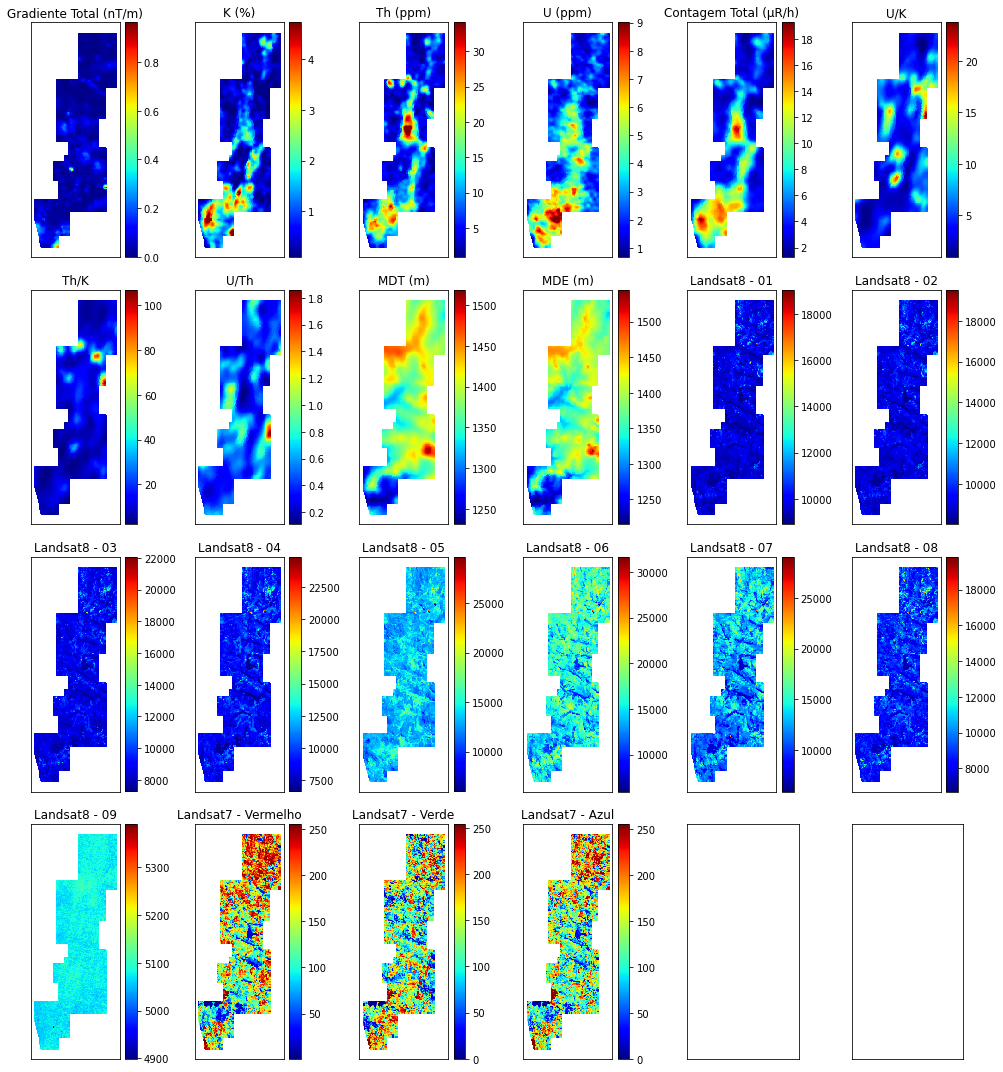

In [64]:
fig, axs = plt.subplots(nrows = 4, ncols = 6, figsize = (14, 15),
                        subplot_kw = {'xticks' : [], 'yticks' : []})

X, Y = COORD[0], COORD[1]

for ax, f in zip(axs.flat, dic_features):
    g = ax.scatter(data = df, x = X, y = Y, c = f, cmap = cm, s = sz, marker = mk)
    fig.colorbar(g, ax = ax)
    ax.set_title(str(dic_features[f]))

plt.tight_layout();

### Descrição univariada

##### Estatísticas dos dados geofísicos

In [62]:
sumStats(df = df[GF])

,X̅,50%,Min,10%,99.5%,Max,Amp,S²,S,Cᵥ,Skew
GT,0.048625,0.033145,0.000000,0.011728,0.272914,0.962399,0.962399,0.002544,0.050442,1.037373,4.250229
K,1.019616,0.640000,0.102035,0.190000,4.718372,4.719150,4.617115,0.910206,0.954047,0.935692,1.461631
TH,9.012547,6.450000,0.904060,2.600000,34.057678,34.077900,33.173840,49.000155,7.000011,0.776696,1.235449
U,3.428294,2.945000,0.680000,1.520000,9.008372,9.009150,8.329150,3.184647,1.784558,0.520538,0.838544
CT,6.370295,4.930000,1.280000,2.460000,17.220000,19.280000,18.000000,15.867890,3.983452,0.625317,0.877143
U_K,5.380546,4.420000,0.970000,2.120000,18.119150,23.730000,22.760000,11.518617,3.393909,0.630774,1.518701
TH_K,12.626573,9.840000,2.230000,5.310000,74.419150,106.870000,104.640000,105.673929,10.279783,0.814139,3.621432
U_TH,0.479001,0.450000,0.110000,0.270000,1.290000,1.860000,1.750000,0.040191,0.200478,0.418534,1.401608


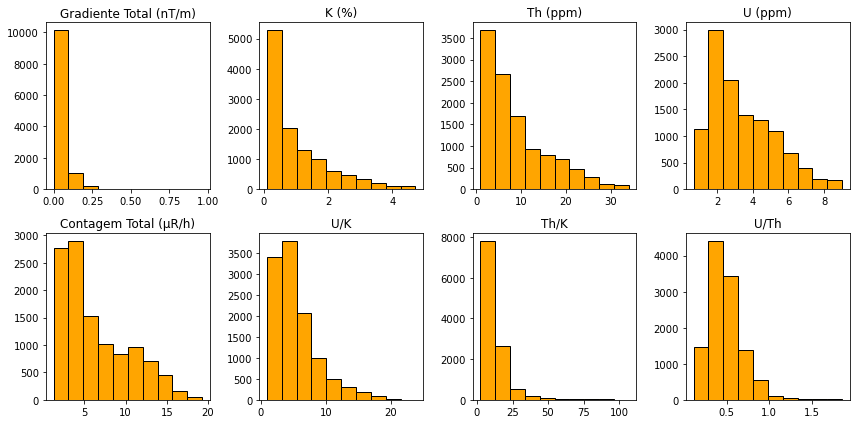

In [69]:
fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize = (12, 6))

for ax, gf in zip(axs.flat, GF):
    g = ax.hist(df[gf], color = col, edgecolor = ec)
    ax.set_title(str(dic_features[gf]))

plt.tight_layout();

- Todas as features geofísicas apresentam distribuições assimétricas positivas;

- As features geofísicas tendem a ser as mais erráticas do banco de dados, com destaque para `SIGNAL` que, por sua vez, apresenta um Cᵥ ~ 1.04.

##### Estatísticas dos sensores remotos

In [72]:
sumStats(df = df[SR])

,X̅,50%,Min,10%,99.5%,Max,Amp,S²,S,Cᵥ,Skew
MDT,1376.713832,1383.765,1231.48,1309.447,1481.67555,1518.86,287.38,2.383816e+03,48.824333,0.035464,-0.751587
MDE,1371.491067,1379.000,1215.00,1299.000,1480.91500,1545.00,330.00,2.662541e+03,51.599815,0.037623,-0.781676
B01,9789.359345,9680.000,8905.00,9301.000,12100.06500,19037.00,10132.00,2.688853e+05,518.541536,0.052970,2.704648
B02,9127.988965,9012.000,8010.00,8523.000,11752.83000,19540.00,11530.00,3.767398e+05,613.791292,0.067243,2.429767
B03,8805.247154,8656.000,7272.00,8004.000,12105.57500,22051.00,14779.00,6.268228e+05,791.721443,0.089915,2.342953
B04,9057.911105,8924.000,6613.00,7781.700,13584.02500,24846.00,18233.00,1.360990e+06,1166.614752,0.128795,1.555522
B05,13390.707304,13203.000,5960.00,11855.000,17983.66000,29667.00,23707.00,2.014171e+06,1419.215064,0.105985,0.912569
B06,15849.828254,15917.500,5962.00,12605.400,22480.51500,31637.00,25675.00,6.095484e+06,2468.903304,0.155768,-0.011219
B07,12359.669207,12247.000,5885.00,9496.500,19146.06500,29052.00,23167.00,5.197637e+06,2279.832696,0.184457,0.312071
B08,8833.474864,8675.500,6703.00,7789.000,13067.70500,19822.00,13119.00,1.002425e+06,1001.211582,0.113343,2.106471


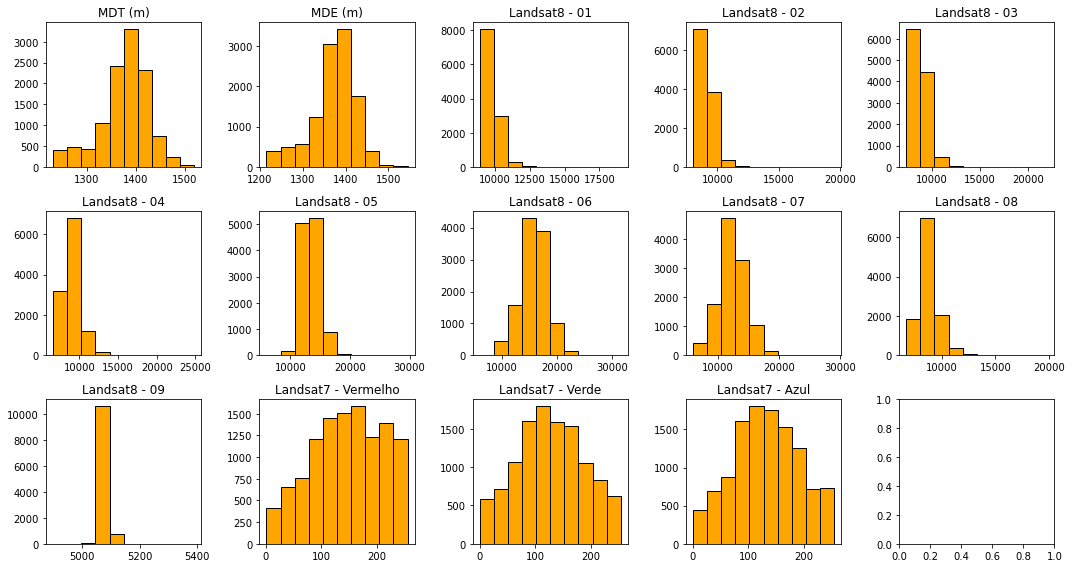

In [78]:
fig, axs = plt.subplots(nrows = 3, ncols = 5, figsize = (15, 8))

for ax, sr in zip(axs.flat, SR):
    g = ax.hist(df[sr], color = col, edgecolor = ec)
    ax.set_title(str(dic_features[sr]))

plt.tight_layout();

- A grande maioria dos sensores remotos apresentam distribuições assimétricas positivas ou quase simétricas;

- Apenas três features apresentam distribuições assimétricas negativas: `MDE`, `MDT` e `LAND7_R`.

- Em geral, os sensores remotos tendem a ser pouco erráticos, com destaque para `B09` que, por sua vez, apresenta um Cᵥ ~ 0.03.

##### Análise da dispersão das features

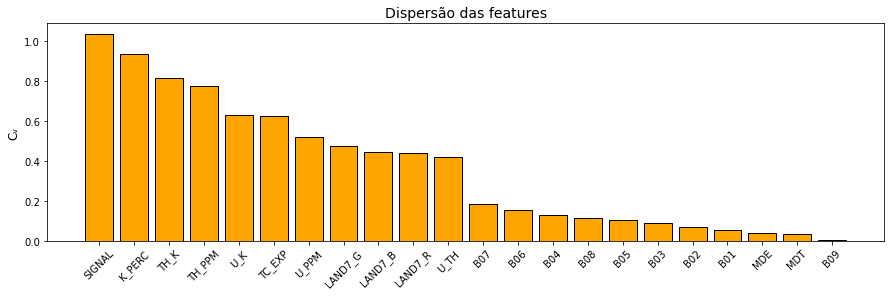

In [24]:
disp = sumStats(df = df[FEAT]).sort_values(by = 'Cᵥ', ascending = False)['Cᵥ']

plt.figure(figsize = (15,4))

plt.bar(x = disp.index, height = disp.values,
       color = col, edgecolor = ec)

plt.title("Dispersão das features", size = 14)
plt.xticks(rotation = 45)
plt.ylabel("Cᵥ", size = 12);

- Os sensores remotos tendem a ser muito pouco erráticos (Cᵥ < 0.2), com exceção das features `LAND7_R`, `LAND7_G` e `LAND7_B` que, por sua vez, encontram-se entre as 10 features mais erráticas;

- Os dados geofísicos são, em geral os que apresentam maior dispersão, com exceção da razão `U_TH`.

##### Gráfico de barras unidades litoestratigráficas

In [25]:
# Criação de dataframe com as variáveis utilizadas nos gráfico
df_lito_count = pd.DataFrame(df['UNID'].value_counts())                             # Criação do dataframe
total_lito_count = df['UNID'].value_counts().sum()                                  # Contagem total
df_lito_count['UNID_PERC'] = (df_lito_count['UNID'] / total_lito_count) * 100       # Criação de coluna de frequência percentual
freq_abs = df_lito_count['UNID']                                                    # Variável de frequência absoluta
freq_perc = df_lito_count['UNID_PERC'].round(2)                                     # Variável de frequência percentual

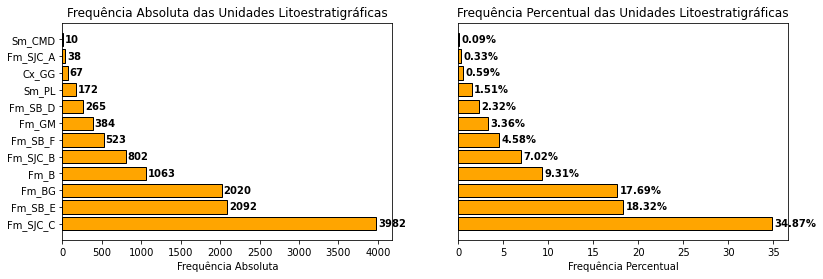

In [26]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(13,4))

# Gráfico frequência absoluta
ax1.barh(list(df_lito_count.index),
         freq_abs,
         color = col,
         edgecolor = ec)

for i, v in enumerate(freq_abs):
    ax1.text(v + 20, i, str(v), va='center', fontweight='bold')
    
plt.setp(ax1,title="Frequência Absoluta das Unidades Litoestratigráficas",
         xlabel="Frequência Absoluta")


# Gráfico frequência percentual
ax2.barh(list(df_lito_count.index),
         freq_perc,
         color = col,
         edgecolor = ec)

ax2.axes.get_yaxis().set_visible(False)

for i, v in enumerate(freq_perc):
    ax2.text(v + 0.25, i, str(v) + "%", va='center', fontweight='bold')
    
plt.setp(ax2,title="Frequência Percentual das Unidades Litoestratigráficas",
         xlabel="Frequência Percentual");

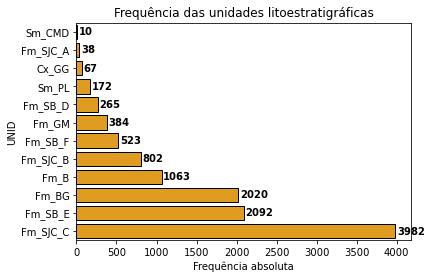

In [102]:
order = df.UNID.value_counts().sort_values().index
values = df.UNID.value_counts().sort_values().values

p = sns.countplot(y = 'UNID', data = df, color = col, edgecolor = ec, order = order)

for i, v in enumerate(values):
    p.text(v + 30, i, str(v), va='center', fontweight='bold')
    
plt.title("Frequência das unidades litoestratigráficas")
plt.xlabel("Frequência absoluta");

- As 3 unidades litoestratigráficas mais frequentes (`Fm_SJC_C`, `Fm_SB_E` e `Fm_BG`) representam mais de 70% do total de ocorrências;

- Portanto, as classes estão claramente desbalanceadas e algumas abordagens serão conduzidas posteriormente para lidar com esse problema.

### Descrição Bivariada

##### Mapas de calor - coeficiente de correlação de Spearman

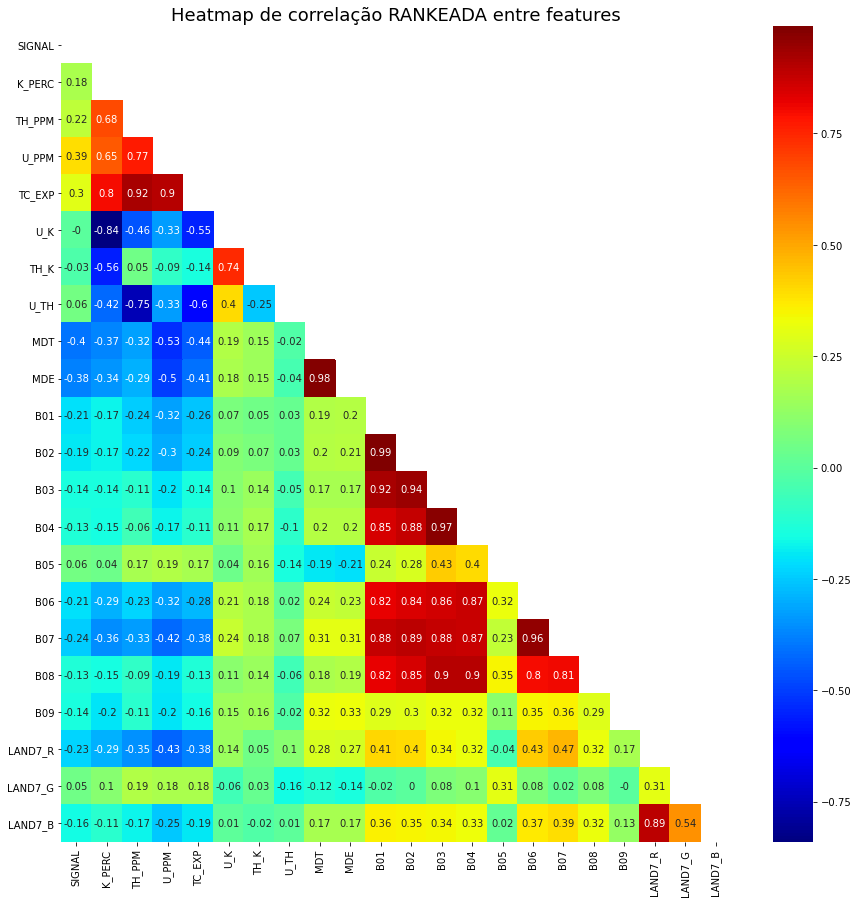

In [27]:
mx_spear = df[FEAT].corr(method = 'spearman').round(2)

mask = np.triu(np.ones_like(mx_spear, dtype = np.bool))

plt.figure(figsize = (15, 15))
plt.title ('Heatmap de correlação RANKEADA entre features', size = 18)

ax = sns.heatmap(
                 mx_spear,
                 annot = True,
                 cmap = cm,
                 cbar = True,
                 mask = mask
                )

##### Mapas de calor - Coeficiente de Correlação de Pearson

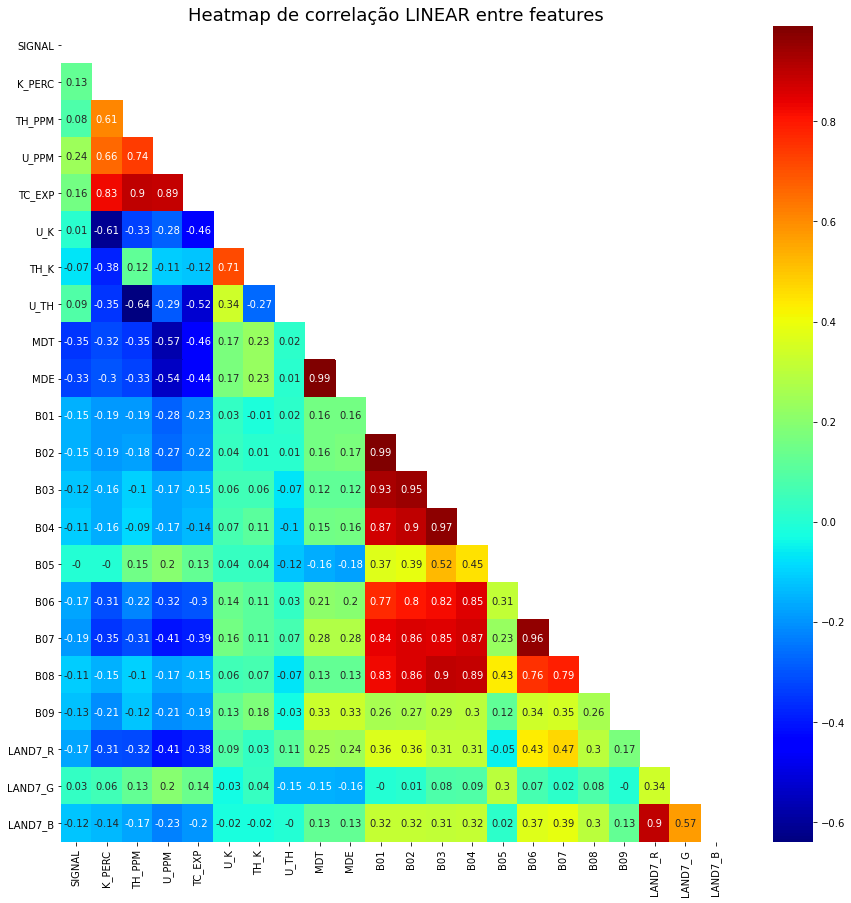

In [28]:
mx_pear = df[FEAT].corr().round(2)

mask = np.triu(np.ones_like(mx_pear, dtype = np.bool))

plt.figure(figsize = (15, 15))
plt.title ('Heatmap de correlação LINEAR entre features', size = 18)

ax = sns.heatmap(
                 mx_pear,
                 annot = True,
                 cmap = cm,
                 cbar = True,
                 mask = mask
                )

- As features `U_PPM`, `TH_PPM` e `K_PERC` apresentam correlações lineares positivas médias a fortes entre si;

- As features `U_PPM`, `TH_PPM` e `K_PERC` apresentam forte correlação linear positiva com a variável `TC_EXP`, o que já era esperado;

- A feature `SIGNAL` não apresenta correlação (linear ou monotônica) significativa com nenhuma outra feature;

- As features Landsat 8 apresentam fortíssimas correlações lineares entre si. Esse fato pode implicar em multicolinearidade e deve ser tratado cautelosamente caso um algoritmo linear seja utilizado.As únicas exceções são `B05` e `B09`;

- As features `MDE` e `MDT` são particamente idênticas. Apenas uma delas deve ser selecionada para treinar os algoritmos;

- A feature `MDT` apresenta uma correlação linear negativa média com `U_PPM`. Esse fato é interessante e deve ser investigado!

##### Features geofísicas x target

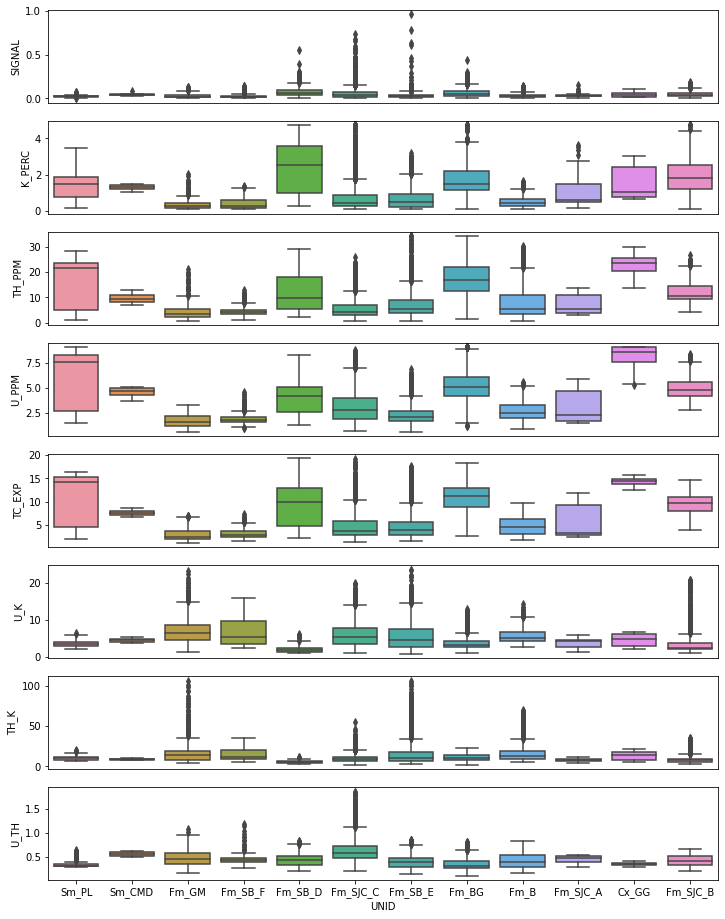

In [29]:
plotBoxplots(cols = GF);

- As features radiométricas apresentam uma variabilidade significativa quando agrupadas pelas unidades litoestratigráficas. Essas variáveis possivelmente serão as **mais importantes** para treinar os modelos;

- Em contrapartida, a variável magnetométrica `SIGNAL` apresenta-se praticamente estacionária quando agrupada pelas unidades.

##### Sensores remotos x target

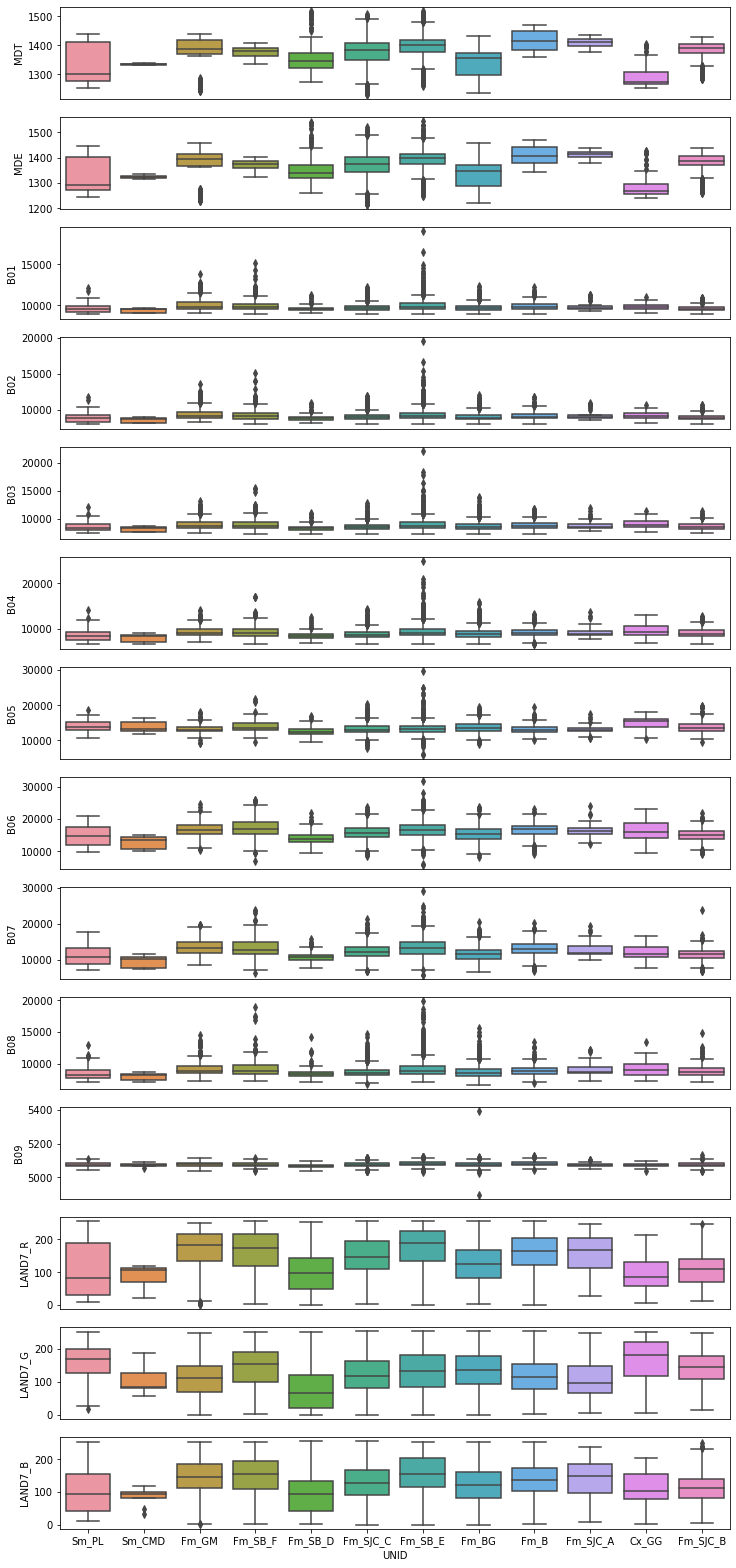

In [30]:
plotBoxplots(cols = SR);

- As features Landsat 8 apresentam uma variabilidade extremamente baixa quando agrupadas pelas unidades. Nesse sentido, possivelmente, essas variáveis não serão úteis para treinar os modelos;

- Em contrapartida, as features geofísicas, juntamente com `MDE` / `MDT`, `LAND7_R`, `LAND7_G` e `LAND7_B`, apresentam uma dispersão significativa quando agrupadas pelas unidades. Essas variáveis possivelmente contribuirão positivamente para as predições.

##### Estatísticas de K (%) por unidade litoestratigráfica

In [31]:
sumByLito(f = 'K_PERC')

UNID              Cx_GG         Fm_B        Fm_BG       Fm_GM     Fm_SB_D  \
K_PERC count  67.000000  1063.000000  2020.000000  384.000000  265.000000   
       mean    1.530149     0.506757     1.729954    0.379748    2.446235   
       std     0.809286     0.263806     0.878516    0.325887    1.403461   
       min     0.670000     0.102035     0.102035    0.102035    0.320000   
       10%     0.710000     0.210000     0.800000    0.110000    0.568000   
       50%     1.050000     0.450000     1.520000    0.270000    2.520000   
       99.5%   2.990400     1.417600     4.719150    1.739550    4.719150   
       max     3.030000     1.640000     4.719150    2.060000    4.719150   

UNID              Fm_SB_E     Fm_SB_F   Fm_SJC_A    Fm_SJC_B     Fm_SJC_C  \
K_PERC count  2092.000000  523.000000  38.000000  802.000000  3982.000000   
       mean      0.714696    0.432153   1.232105    1.897234     0.793884   
       std       0.636324    0.310973   0.972995    1.031912     0.869994   
       min       0.102035    0.102035   0.170000    0.102035     0.102035   
       10%       0.130000    0.110000   0.437000    0.391000     0.180000   
       50%       0.490000    0.320000   0.610000    1.850000     0.440000   
       99.5%     2.820000    1.341700   3.611500    4.719150     4.612850   
       max       3.180000    1.400000   3.630000    4.719150     4.719150   

UNID             Sm_CMD       Sm_PL  
K_PERC count  10.000000  172.000000  
       mean    1.323000    1.442733  
       std     0.159308    0.821266  
       min     1.040000    0.210000  
       10%     1.139000    0.321000  
       50%     1.340000    1.520000  
       99.5%   1.499100    3.418700  
       max     1.500000    3.470000

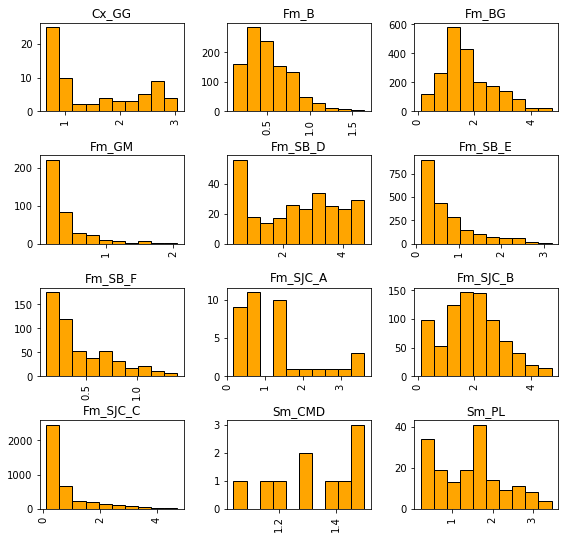

In [32]:
histByLito(f = 'K_PERC');

- As unidades que apresentam MAIORES concentrações de `K_PERC` são **Fm_SB_D** e **Fm_SJC_B**;

- As unidades que apresentam MENORES concentrações de `K_PERC` são **Fm_GM** e **Fm_SB_F**.

##### Estatísticas de U (ppm) por unidade litoestratigráfica

In [33]:
sumByLito(f = 'U_PPM')

UNID             Cx_GG         Fm_B        Fm_BG       Fm_GM     Fm_SB_D  \
U_PPM count  67.000000  1063.000000  2020.000000  384.000000  265.000000   
      mean    8.048590     2.671477     5.201776    1.723854    4.091132   
      std     1.123448     0.927466     1.407053    0.639106    1.654864   
      min     5.260000     0.890000     1.230000    0.680000    1.330000   
      10%     5.976000     1.590000     3.430000    0.950000    1.622000   
      50%     8.580000     2.510000     5.140000    1.605000    4.220000   
      99.5%   9.009150     5.193800     9.009150    3.183400    7.913600   
      max     9.009150     5.550000     9.009150    3.280000    8.260000   

UNID             Fm_SB_E     Fm_SB_F   Fm_SJC_A    Fm_SJC_B     Fm_SJC_C  \
U_PPM count  2092.000000  523.000000  38.000000  802.000000  3982.000000   
      mean      2.330497    1.932084   3.272632    4.941858     3.129367   
      std       0.936176    0.473562   1.656748    1.003734     1.555412   
      min       0.680000    0.990000   1.490000    2.790000     0.750000   
      10%       1.420000    1.450000   1.530000    3.740000     1.450000   
      50%       2.160000    1.860000   2.320000    4.830000     2.780000   
      99.5%     6.039950    4.151900   5.864450    8.149350     8.080950   
      max       6.830000    4.580000   5.870000    8.340000     8.750000   

UNID            Sm_CMD       Sm_PL  
U_PPM count  10.000000  172.000000  
      mean    4.598000    5.993007  
      std     0.489144    2.797706  
      min     3.660000    1.560000  
      10%     3.975000    2.140000  
      50%     4.745000    7.605000  
      99.5%   5.126400    9.009150  
      max     5.130000    9.009150

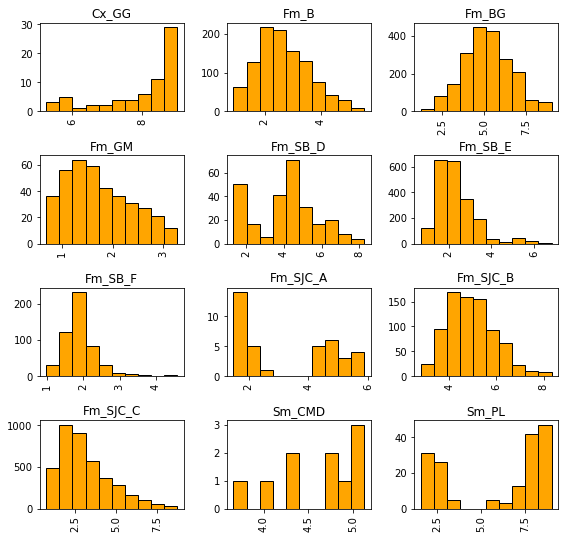

In [34]:
histByLito(f = 'U_PPM');

- As unidades que apresentam MAIORES concentrações de `U_PPM` são **Cx_GG** e **Fm_BG**;

- As unidades que apresentam MENORES concentrações de `U_PPM` são **Fm_GM** e **Fm_SB_F**.

##### Estatísticas de Th (ppm) por unidade litoestratigráfica

In [35]:
sumByLito(f = 'TH_PPM')

UNID              Cx_GG         Fm_B        Fm_BG       Fm_GM     Fm_SB_D  \
TH_PPM count  67.000000  1063.000000  2020.000000  384.000000  265.000000   
       mean   22.975672     7.865703    17.449252    4.520919   11.916642   
       std     3.797475     5.932064     6.969378    3.687290    7.481756   
       min    13.870000     0.904060     1.660000    0.904060    2.200000   
       10%    18.066000     2.362000     9.310000    1.345000    3.578000   
       50%    23.500000     5.520000    17.040000    3.375000    9.630000   
       99.5%  29.808500    28.277700    34.077900   19.395900   27.829600   
       max    29.990000    30.320000    34.077900   21.160000   29.120000   

UNID              Fm_SB_E     Fm_SB_F   Fm_SJC_A    Fm_SJC_B     Fm_SJC_C  \
TH_PPM count  2092.000000  523.000000  38.000000  802.000000  3982.000000   
       mean      7.011018    4.701243   7.523158   12.193379     5.717703   
       std       4.983653    2.037439   3.869736    4.390383     4.230976   
       min       0.910000    1.080000   3.050000    4.100000     0.904060   
       10%       2.740000    2.752000   3.344000    8.173000     2.101000   
       50%       5.480000    4.240000   5.460000   10.490000     4.320000   
       99.5%    30.389750   11.657800  13.550800   24.049750    21.050450   
       max      34.077900   12.920000  13.610000   26.580000    26.140000   

UNID             Sm_CMD       Sm_PL  
TH_PPM count  10.000000  172.000000  
       mean    9.738000   16.320814  
       std     2.039917    9.277814  
       min     6.840000    1.290000  
       10%     7.569000    2.756000  
       50%     9.310000   21.630000  
       99.5%  12.832800   28.165100  
       max    12.840000   28.490000

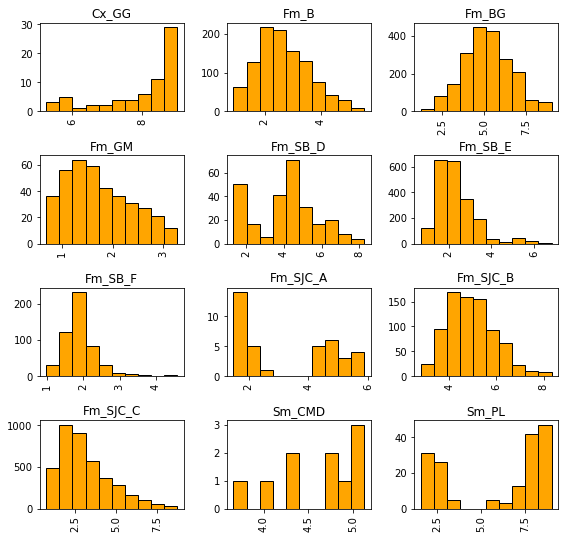

In [36]:
histByLito(f = 'U_PPM');

- As unidades que apresentam MAIORES concentrações de `TH_PPM` são **Cx_GG** e **Fm_BG** (mesmas do `U_PPM`);

- As unidades que apresentam MENORES concentrações de `TH_PPM` são **Fm_GM** e **Fm_SB_F** (mesmas do `U_PPM`).

##### Estatísticas de contagem total (μR/h) por unidade litoestratigráfica

In [37]:
sumByLito(f = 'TC_EXP')

UNID              Cx_GG         Fm_B        Fm_BG       Fm_GM     Fm_SB_D  \
TC_EXP count  67.000000  1063.000000  2020.000000  384.000000  265.000000   
       mean   14.321194     4.876453    10.888317    2.998047    9.683321   
       std     0.754621     1.941457     3.132546    1.379104    4.856235   
       min    12.470000     1.810000     2.700000    1.280000    2.230000   
       10%    13.256000     2.470000     6.689000    1.533000    3.100000   
       50%    14.450000     4.710000    11.280000    2.505000    9.860000   
       99.5%  15.727500     9.568300    17.939550    6.980850   19.141200   
       max    15.810000     9.770000    18.290000    7.020000   19.280000   

UNID              Fm_SB_E     Fm_SB_F   Fm_SJC_A    Fm_SJC_B     Fm_SJC_C  \
TC_EXP count  2092.000000  523.000000  38.000000  802.000000  3982.000000   
       mean      4.618815    3.233537   6.176316    9.535449     4.945826   
       std       2.482388    1.063460   3.555941    2.313963     3.196253   
       min       1.540000    1.520000   2.480000    3.940000     1.410000   
       10%       2.420000    2.202000   2.721000    6.262000     2.380000   
       50%       3.950000    2.860000   3.290000    9.780000     3.660000   
       99.5%    15.934500    6.646300  11.860400   14.549850    14.790450   
       max      17.690000    7.320000  11.890000   14.760000    19.080000   

UNID             Sm_CMD       Sm_PL  
TC_EXP count  10.000000  172.000000  
       mean    7.648000   10.898372  
       std     0.662182    5.467303  
       min     6.650000    2.120000  
       10%     6.929000    2.704000  
       50%     7.630000   14.345000  
       99.5%   8.675600   16.223200  
       max     8.690000   16.360000

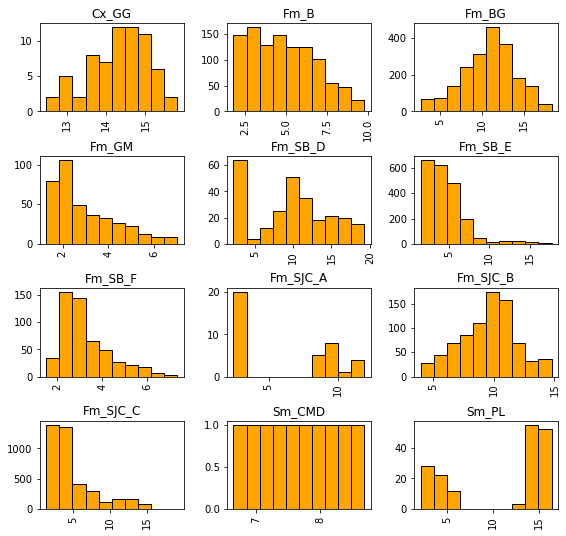

In [38]:
histByLito(f = 'TC_EXP');

- As unidades que apresentam MAIORES concentrações de `TC_EXP` são **Cx_GG** e **Fm_BG** (mesmas do `U_PPM` e `TH_PPM`);

- As unidades que apresentam MENORES concentrações de `TC_EXP` são **Fm_GM** e **Fm_SB_F** (mesmas do `U_PPM` e `TH_PPM`);

- OBS.: a distribuição uniforme apresentada por **Sm_CMD** ocorre em função da baixa densidade amostral dessa unidade (10 valores e 10 *bins*).

##### Estatísticas de sinal análitico (nT/m) por unidade litoestratigráfica

In [39]:
sumByLito(f = 'SIGNAL')

UNID              Cx_GG         Fm_B        Fm_BG       Fm_GM     Fm_SB_D  \
SIGNAL count  67.000000  1063.000000  2020.000000  384.000000  265.000000   
       mean    0.043463     0.030320     0.061803    0.029581    0.083216   
       std     0.026423     0.023523     0.051433    0.024113    0.070785   
       min     0.012960     0.001470     0.001725    0.003204    0.008845   
       10%     0.018700     0.010169     0.014981    0.007671    0.027161   
       50%     0.036008     0.023046     0.046121    0.020791    0.061637   
       99.5%   0.105040     0.131177     0.248779    0.121511    0.361081   
       max     0.105082     0.144330     0.437557    0.129563    0.550258   

UNID              Fm_SB_E     Fm_SB_F   Fm_SJC_A    Fm_SJC_B     Fm_SJC_C  \
SIGNAL count  2092.000000  523.000000  38.000000  802.000000  3982.000000   
       mean      0.036868    0.025665   0.036983    0.047027     0.056950   
       std       0.044899    0.023980   0.029665    0.031436     0.059477   
       min       0.001291    0.003913   0.004470    0.004734     0.000000   
       10%       0.011163    0.008551   0.015105    0.014868     0.012374   
       50%       0.025521    0.017815   0.026017    0.038828     0.037942   
       99.5%     0.192202    0.128163   0.146022    0.173542     0.370855   
       max       0.962399    0.142053   0.155228    0.190429     0.743154   

UNID             Sm_CMD       Sm_PL  
SIGNAL count  10.000000  172.000000  
       mean    0.045278    0.028506  
       std     0.014826    0.011342  
       min     0.028408    0.003918  
       10%     0.030325    0.016186  
       50%     0.042953    0.026073  
       99.5%   0.080198    0.072230  
       max     0.081434    0.076001

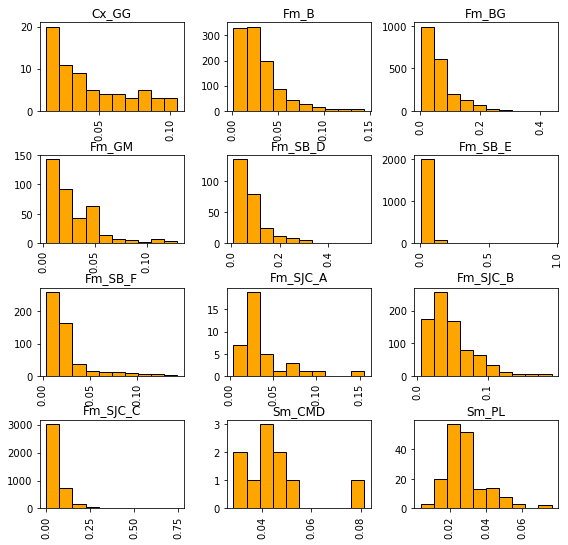

In [40]:
histByLito(f = 'SIGNAL');

- As unidades que apresentam MAIORES concentrações de `SIGNAL` são **Fm_SB_D** e **Fm_BG**;

- As unidades que apresentam MENORES concentrações de `SIGNAL` são **Fm_SB_F** e **Sm_PL**.